# Porto Seguro’s Safe Driver Prediction

## Prerequisites
Please make sure the following Python distributions and packages were installed.

* [Anaconda](https://anaconda.org)
* [XGBoost](https://github.com/dmlc/xgboost)
* [LightGBM](https://github.com/Microsoft/LightGBM) - needed by week 2
* [Keras](https://keras.io) - not needed by week 2
* [Tensorflow](https://www.tensorflow.org) - not needed by week 2
* [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) -  needed by week 2
* [seaborn](https://seaborn.pydata.org)
* [bokeh](http://bokeh.pydata.org)

You'll also need to create the following sub-folders in your working folder:

* input
   
   To store all the data files downloaded from Kaggle
   
   
* output
    
    To store submission files
   
   
* python
    
    To store python scripts and ipython notebooks including this one.

In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier


%matplotlib inline 


# Define functions for normalized-gini caculation

In [2]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True


def gini_s(actual, pred, cmpcol = 0, sortcol = 1):
#     pred=pred[:,1]
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized_s(a, p):
    p=p[:,1]
    return gini_s(a, p) / gini(a, a)



gini_scorer = metrics.make_scorer(gini_normalized_s, greater_is_better=True, needs_proba=True)

def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = model_selection.GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = gini_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

# Data initialization

In [3]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
train_size = train_data.shape[0]

## Merge training and testing data
So we don't have to perform transformations twice

In [4]:
full_data=pd.concat([train_data,test_data])

## Group variables

In [5]:
cat_vars = [var for var in full_data.columns if 'cat' in var]

num_vars = [var for var in full_data.columns if 'cat' not in var and var != 'id' and var!='target']

id_var = 'id'
target_var = 'target'

# Feature engineering

## Missing value imputation

In this competition, missing values have already been pre-imputed as -1 (see [Data Description](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data)), so technically we don't have to do any imputation to make the data work with most algorithms. 

However, XGBoost and LightGBM have a unique way of dealing with missing values which tend to be effective most of the time. By default, the assume Nan as missing value and would try to create splitting point for those samples with Nan. I would be interesting to try the followings and see which works better:

1. Use the data as is (leave -1 in the data)
2. Convert -1 to Nan, so both XGBoost and LightGBM will automatically deal with missing value

## Pre-processing

### Categorical features - label encoding

Label encoding is not really necessary for this competition as all categorical features have already been digitalized. I'm including this just for your reference.


In [6]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].fillna(-1))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding ps_car_01_cat
Label Encoding ps_car_02_cat
Label Encoding ps_car_03_cat
Label Encoding ps_car_04_cat
Label Encoding ps_car_05_cat
Label Encoding ps_car_06_cat
Label Encoding ps_car_07_cat
Label Encoding ps_car_08_cat
Label Encoding ps_car_09_cat
Label Encoding ps_car_10_cat
Label Encoding ps_car_11_cat
Label Encoding ps_ind_02_cat
Label Encoding ps_ind_04_cat
Label Encoding ps_ind_05_cat
Label-encoded feaures: ['ps_car_01_cat_le', 'ps_car_02_cat_le', 'ps_car_03_cat_le', 'ps_car_04_cat_le', 'ps_car_05_cat_le', 'ps_car_06_cat_le', 'ps_car_07_cat_le', 'ps_car_08_cat_le', 'ps_car_09_cat_le', 'ps_car_10_cat_le', 'ps_car_11_cat_le', 'ps_ind_02_cat_le', 'ps_ind_04_cat_le', 'ps_ind_05_cat_le']


### Categorical features - one hot encoding¶

You don't want to concatenate the converted OHE features with the original dataframe(full_data) becuase it would exponentially enlarge the size of the dataframe. In fact, it's recommended to use scipy.sparse.hstack to concatenate the data which you will see in the following sections.

In [7]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))


OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]

print ("OHE_sparse size :" ,OHE_sparse.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

One-hot-encoding finished in 11.155560 seconds
OHE_sparse size : (1488028, 184)
One-hot encoded catgorical feature samples : ['ps_car_01__-1', 'ps_car_01__0', 'ps_car_01__1', 'ps_car_01__2', 'ps_car_01__3', 'ps_car_01__4', 'ps_car_01__5', 'ps_car_01__6', 'ps_car_01__7', 'ps_car_01__8', 'ps_car_01__9', 'ps_car_01__10', 'ps_car_01__11', 'ps_car_02__-1', 'ps_car_02__0', 'ps_car_02__1', 'ps_car_03__-1', 'ps_car_03__0', 'ps_car_03__1', 'ps_car_04__0', 'ps_car_04__1', 'ps_car_04__2', 'ps_car_04__3', 'ps_car_04__4', 'ps_car_04__5', 'ps_car_04__6', 'ps_car_04__7', 'ps_car_04__8', 'ps_car_04__9', 'ps_car_05__-1', 'ps_car_05__0', 'ps_car_05__1', 'ps_car_06__0', 'ps_car_06__1', 'ps_car_06__2', 'ps_car_06__3', 'ps_car_06__4', 'ps_car_06__5', 'ps_car_06__6', 'ps_car_06__7', 'ps_car_06__8', 'ps_car_06__9', 'ps_car_06__10', 'ps_car_06__11', 'ps_car_06__12', 'ps_car_06__13', 'ps_car_06__14', 'ps_car_06__15', 'ps_car_06__16', 'ps_car_06__17', 'ps_car_07__-1', 'ps_car_07__0', 'ps_car_07__1', 'ps_car_08_

## Numeric features

For the first two two weeks we will be using XGBoost/LightGBM which typically don't require pre-processing for numeric features so we will skip this part until week 3.

# Modelling

We all run XGBoost models using a couple of combinations of features as well as with different missing value settings just to see how differently they perform.


## Exclude cal features

In [8]:
calc_vars = [var for var in full_data.columns if 'calc' in var]
print (calc_vars)

full_vars = num_vars

for calc_var in calc_vars:
    if calc_var in full_vars:
        full_vars.remove(calc_var)
    
    
train_x = full_data[full_vars].fillna(-1)[:train_size].values
train_y = full_data['target'][:train_size].values
test_x = full_data[full_vars].fillna(-1)[train_size:].values
ids = full_data[train_size:].id.values

# concatenate dense features with sparse features
train_x = sparse.hstack([train_x,  
                         OHE_sparse[:train_size]]
                       ).toarray()

test_x = sparse.hstack([test_x,  
                         OHE_sparse[train_size:]]
                       ).toarray()

train_y = full_data['target'][:train_size].values

print ('train data size:', train_x.shape, 'test data size:', test_x.shape)    
    

['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
train data size: (595212, 207) test data size: (892816, 207)


In [9]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.1,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1)),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)


{'gamma': 0, 'colsample_bytree': 1, 'subsample': 1, 'objective': 'binary:logistic', 'seed': 1234, 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1}
[0]	train-error:0.0363986+1.21095e-05	train-gini:0.228237+0.00156151	test-error:0.0365216+4.2856e-05	test-gini:0.213187+0.00846963
[50]	train-error:0.0364186+1.02489e-05	train-gini:0.341019+0.00161828	test-error:0.036451+1.46561e-05	test-gini:0.273863+0.00644958
[100]	train-error:0.0364056+8.89044e-06	train-gini:0.395477+0.000939415	test-error:0.0364562+1.6216e-05	test-gini:0.280889+0.00668435
[150]	train-error:0.0363918+9.45304e-06	train-gini:0.431946+0.00307103	test-error:0.0364578+1.49853e-05	test-gini:0.27932+0.00614667
best score: 0.2814588 best iterations: 109


In [10]:
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eta': 0.1,
    'seed': 1234}

print(xgb_params)

cv_results = xgb.cv(xgb_params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, # custom evaluation metric
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

best_xgb_score = cv_results['test-gini-mean'].max()
best_xgb_iteration = len(cv_results)

print('best score:', best_xgb_score, 'best iterations:', best_xgb_iteration)



{'gamma': 0, 'colsample_bytree': 1, 'subsample': 1, 'objective': 'binary:logistic', 'seed': 1234, 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1}
[0]	train-error:0.0363964+1.29089e-05	train-gini:0.228248+0.00147397	test-error:0.0365198+4.28644e-05	test-gini:0.213195+0.00846143
[50]	train-error:0.0364212+1.10526e-05	train-gini:0.342565+0.00100459	test-error:0.0364474+1.35588e-05	test-gini:0.272543+0.00635006
[100]	train-error:0.0364084+1.13772e-05	train-gini:0.400851+0.00185054	test-error:0.0364494+1.69068e-05	test-gini:0.279965+0.00652896
[150]	train-error:0.036392+1.13137e-05	train-gini:0.438264+0.00256642	test-error:0.0364526+1.38939e-05	test-gini:0.279326+0.0057657
best score: 0.2803814 best iterations: 116


# Model tuning

## 1. XGBoost
### Manual tuning
#### max_depth

In [ ]:
%%time
scores = []
for max_depth in [5, 6, 7, 8, 9, 10]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = max_depth
    params['min_child_weight'] = 1
    params['colsample_bytree'] = 1
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(max_depth, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_max_depth = scores.sort_values(by='score', ascending=False)[
    'max_depth'].values[0]
print('best max_depth is', best_max_depth)

5 0.2827602 123
6 0.2803814 116
7 0.2796116 91
8 0.2750888 71
9 0.2699426 56
10 0.2640798 61
best max_depth is 5
CPU times: user 5h 46min 7s, sys: 5min, total: 5h 51min 8s
Wall time: 1h 3min 9s


#### min_child_weight

In [ ]:
%%time
scores = []
for min_child_weight in [1, 10, 50, 100]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = min_child_weight
    params['colsample_bytree'] = 1
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(min_child_weight, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_min_child_weight = scores.sort_values(by='score', ascending=False)[
    'min_child_weight'].values[0]
print('best min_child_weight is', best_min_child_weight)

1 0.2827602 123


#### colsample_bytree

In [ ]:
%%time
scores = []
for colsample_bytree in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].min()
    print(colsample_bytree, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_colsample_bytree = scores.sort_values(by='score', ascending=False)[
    'colsample_bytree'].values[0]
print('best colsample_bytree is', best_colsample_bytree)

#### subsample

In [ ]:
%%time
scores = []
for subsample in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = 0
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(subsample, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_subsample = scores.sort_values(by='score', ascending=False)[
    'subsample'].values[0]
print('best subsample is', best_subsample)

#### gamma

In [ ]:
%%time
scores = []
for gamma in [0, 0.5, 1, 1.5, 2]:

    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample
    params['gamma'] = gamma
    params['seed'] = 1234

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)
    best_iteration = len(cv_results)
    best_score = cv_results['test-gini-mean'].max()
    print(gamma, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_gamma = scores.sort_values(by='score', ascending=False)['gamma'].values[0]
print('best gamma is', best_gamma)

In [ ]:
print(best_max_depth, best_min_child_weight,
      best_colsample_bytree, best_subsample, best_gamma)

scores.sort_values(by='score',ascending=False)

### Automated tuning

We will be using Bayesian optimization for automated parameter tuning.

It works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

* https://github.com/fmfn/BayesianOptimization

In [ ]:
xgtrain = xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1))


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
#     params['num_class'] = 3
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = True

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                        num_boost_round=1000000,
                        nfold=5,
                        #            metrics={'mlogloss'},
                        feval=gini_xgb, maximize=True,
                        stratified=True,
                        shuffle=True,
                        seed=1234,
                        early_stopping_rounds=10)

    return cv_results['test-gini-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate,
                              {'max_depth': (3, 10),
                               'min_child_weight': (0, 100),
                               'colsample_bytree': (0.1, 0.7),
                               'subsample': (0.7, 1),
                               'gamma': (0, 2)
                               }
                              )

xgb_BO.maximize(init_points=5, n_iter=40)

#### Show tuning results

In [21]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
32,0.686114,1.169305,5.599073,99.722887,0.716211,0.286065
31,0.683748,0.556857,5.196770,99.981654,0.913247,0.286062
26,0.681606,1.956710,5.453632,99.930183,0.921342,0.285860
29,0.690288,0.145613,6.894344,76.669246,0.824055,0.285745
24,0.699761,0.052297,7.647611,84.625896,0.716369,0.285556


#### Plot scores vs parameters

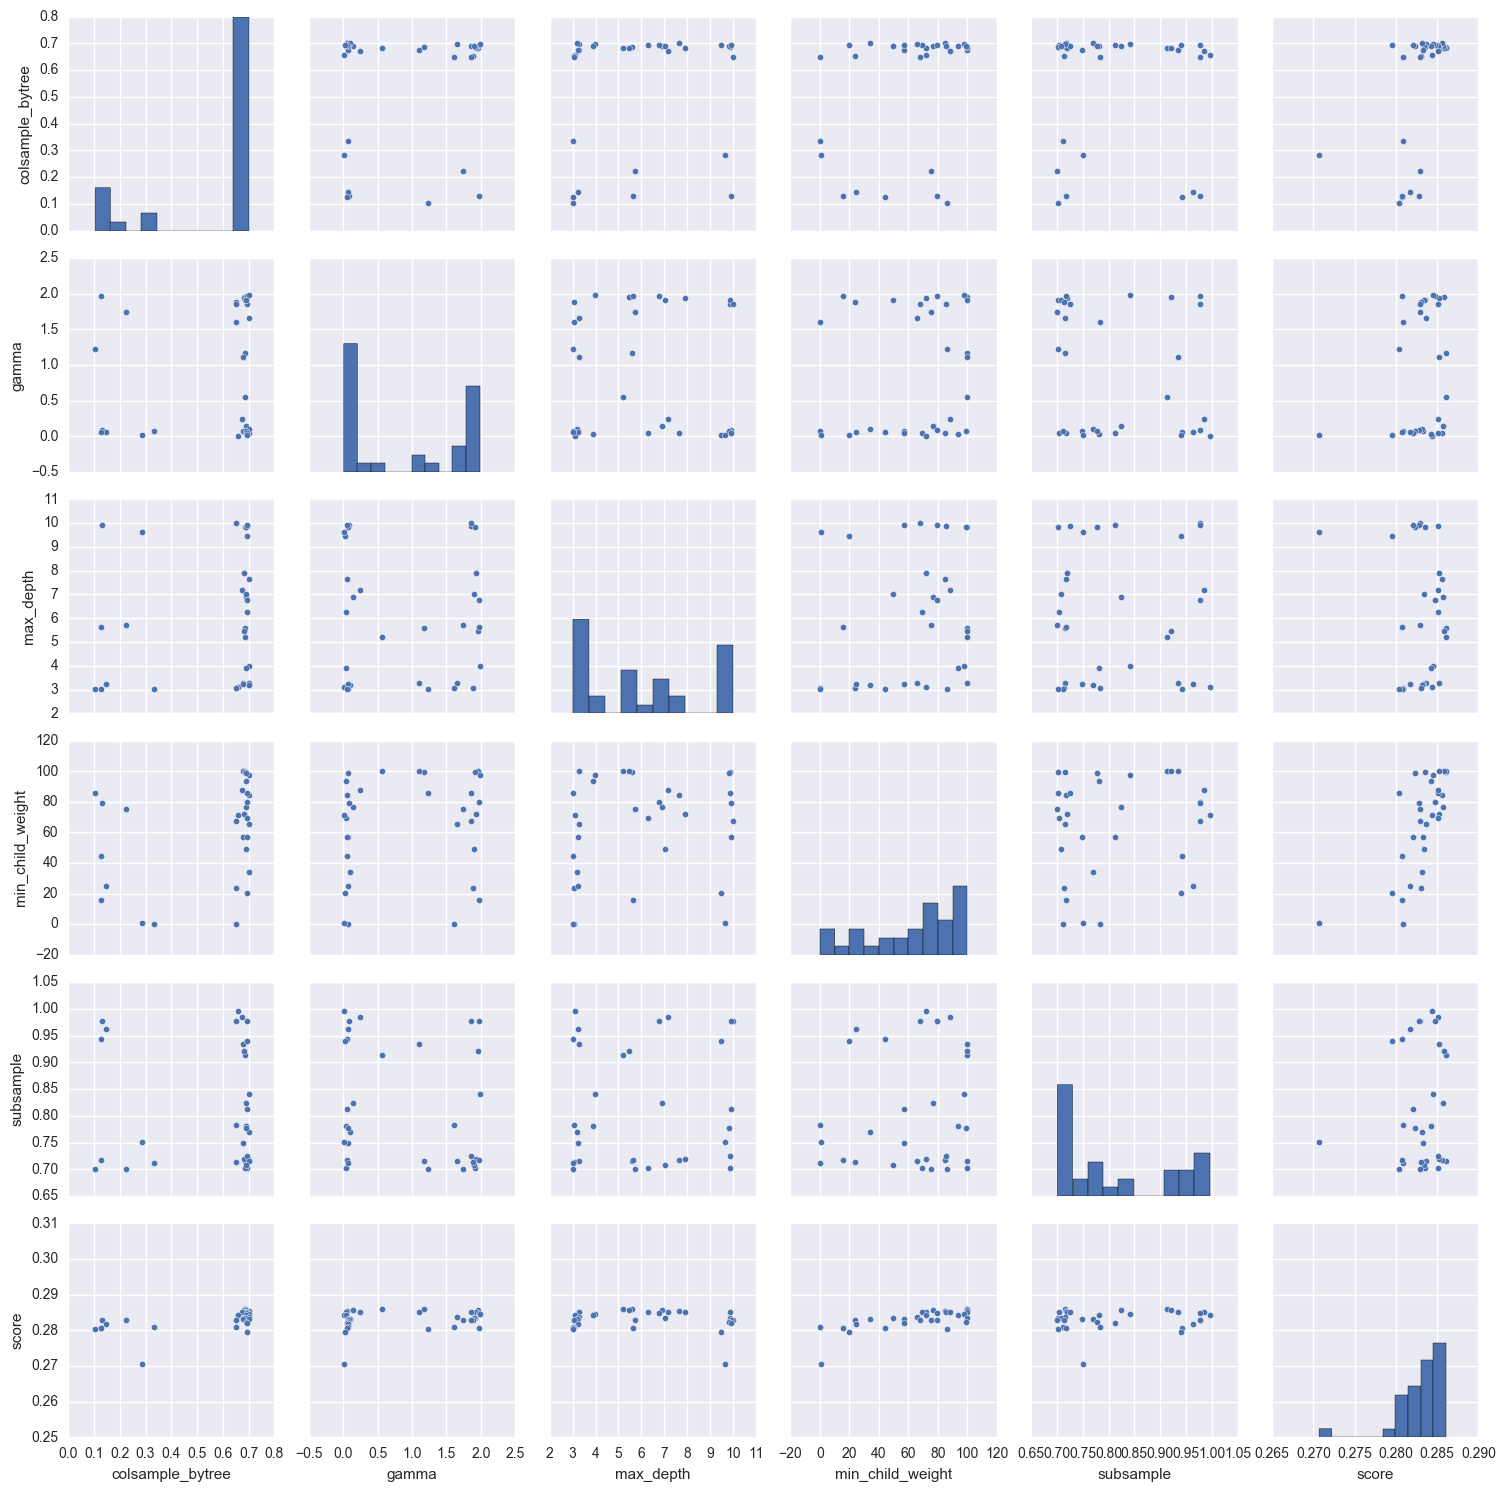

In [23]:
sns.pairplot(xgb_BO_scores)

### Train the model with smaller learning rate

In [ ]:
xgb_params = xgb_BO_scores.iloc[0].to_dict()
xgb_params['objective'] = 'binary:logistic'
xgb_params['eta'] = 0.01  # Smaller

xgb_params['max_depth'] = int(xgb_params['max_depth'])
xgb_params['min_child_weight'] = int(xgb_params['min_child_weight'])
xgb_params['subsample'] = xgb_params['subsample']
xgb_params['colsample_bytree'] = xgb_params['colsample_bytree']
xgb_params['gamma'] = xgb_params['gamma']
xgb_params['seed'] = 1234

cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=-1),
                    num_boost_round=1000000,
                    nfold=5,
                    feval=gini_xgb, maximize=True,
                    stratified=True,
                    shuffle=True,
                    seed=1234,
                    early_stopping_rounds=10)

best_iteration = len(cv_results)
best_score = cv_results['test-gini-mean'].max()
print(best_score, best_iteration)

In [ ]:
model = xgb.train(xgb_params,
                  xgb.DMatrix(train_x, label=train_y.reshape(
                      train_x.shape[0], 1), missing=-1),
                  num_boost_round=best_xgb_iteration
                  )

preds = model.predict(xgb.DMatrix(test_x))

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("../output/sub_xgb_tuned.csv", index=False)

## 2.LightGBM

### Manual tuning
#### max_bin

In [24]:
%%time
scores = []
for max_bin in [100, 255, 400, 600, 800, 1000]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = max_bin

    print(max_bin)

    cv_results = lgb.cv(params,
                        lgb.Dataset(train_x, train_y, max_bin=max_bin),
                        num_boost_round=1000000,
                        nfold=5,
                        early_stopping_rounds=50,
                        feval=gini_lgb,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=100
                        )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print(max_bin, best_iteration, best_score)
    scores.append([max_bin, best_iteration, best_score])

scores = pd.DataFrame(scores, columns=['max_bin', 'iteration', 'score'])
best_max_bin = scores.sort_values(by='score', ascending=False)[
    'max_bin'].values[0]
print('best max_bin is', best_max_bin)

100
[100]	cv_agg's gini: 0.272883 + 0.0129624
[200]	cv_agg's gini: 0.280159 + 0.0114094
100 183 0.280228734826
255
[100]	cv_agg's gini: 0.273645 + 0.012711
[200]	cv_agg's gini: 0.280937 + 0.0120808
255 233 0.281104066787
400
[100]	cv_agg's gini: 0.272214 + 0.0131884
[200]	cv_agg's gini: 0.279531 + 0.0116094
400 226 0.279800224483
600
[100]	cv_agg's gini: 0.272778 + 0.0135331
[200]	cv_agg's gini: 0.280245 + 0.0113494
600 185 0.280610033039
800
[100]	cv_agg's gini: 0.272651 + 0.0133082
[200]	cv_agg's gini: 0.280158 + 0.0119478
800 194 0.280212529426
1000
[100]	cv_agg's gini: 0.272866 + 0.0131199
[200]	cv_agg's gini: 0.280388 + 0.0114486
1000 200 0.280388359873
best max_bin is 255
CPU times: user 44min 51s, sys: 3min 23s, total: 48min 14s
Wall time: 22min 27s


#### num_leaves

In [25]:
%%time
scores = []
for num_leaves in [3, 10, 30, 100, 300, 1000]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = num_leaves

    print(num_leaves)

    cv_results = lgb.cv(params,
                        lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                        num_boost_round=1000000,
                        nfold=5,
                        early_stopping_rounds=50,
                        feval=gini_lgb,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=100
                        )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print(num_leaves, best_score, best_iteration)
    scores.append([num_leaves, best_iteration, best_score])

scores = pd.DataFrame(scores, columns=['num_leaves', 'iteration', 'score'])
best_num_leaves = scores.sort_values(by='score', ascending=False)[
    'num_leaves'].values[0]
print('best num_leaves is', best_num_leaves)

3
[100]	cv_agg's gini: 0.24184 + 0.0148139
[200]	cv_agg's gini: 0.260099 + 0.0146228
[300]	cv_agg's gini: 0.266774 + 0.013883
[400]	cv_agg's gini: 0.270427 + 0.0134213
[500]	cv_agg's gini: 0.272747 + 0.0127301
[600]	cv_agg's gini: 0.274267 + 0.0125175
[700]	cv_agg's gini: 0.275316 + 0.0123477
[800]	cv_agg's gini: 0.276142 + 0.0122766
[900]	cv_agg's gini: 0.276941 + 0.0123148
[1000]	cv_agg's gini: 0.277428 + 0.0123566
[1100]	cv_agg's gini: 0.277924 + 0.012303
[1200]	cv_agg's gini: 0.278359 + 0.0123615
[1300]	cv_agg's gini: 0.278597 + 0.0123491
[1400]	cv_agg's gini: 0.278967 + 0.0123687
[1500]	cv_agg's gini: 0.279168 + 0.0122803
[1600]	cv_agg's gini: 0.279333 + 0.0122967
[1700]	cv_agg's gini: 0.279475 + 0.0123797
3 0.279516553683 1662
10
[100]	cv_agg's gini: 0.264191 + 0.0138285
[200]	cv_agg's gini: 0.277563 + 0.0123439
[300]	cv_agg's gini: 0.279868 + 0.012162
[400]	cv_agg's gini: 0.280636 + 0.0121318
10 0.280690035583 442
30
[100]	cv_agg's gini: 0.272451 + 0.0138891
[200]	cv_agg's gini:

#### feature_fraction

In [26]:
%%time
scores = []
for feature_fraction in [0.2, 0.4, 0.6, 0.8]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = feature_fraction

    cv_results = lgb.cv(params,
                        lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                        num_boost_round=1000000,
                        nfold=5,
                        early_stopping_rounds=50,
                        feval=gini_lgb,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=100
                        )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print(feature_fraction, best_iteration, best_score)
    scores.append([feature_fraction, best_iteration, best_score])

scores = pd.DataFrame(
    scores, columns=['feature_fraction', 'iteration', 'score'])
best_feature_fraction = scores.sort_values(by='score', ascending=False)[
    'feature_fraction'].values[0]
print('best feature_fraction is', best_feature_fraction)

[100]	cv_agg's gini: 0.265516 + 0.0145027
[200]	cv_agg's gini: 0.276034 + 0.0133182
[300]	cv_agg's gini: 0.279491 + 0.0128656
[400]	cv_agg's gini: 0.280272 + 0.0128974
[500]	cv_agg's gini: 0.280961 + 0.0123685
[600]	cv_agg's gini: 0.280995 + 0.0121489
[700]	cv_agg's gini: 0.281342 + 0.0118044
0.2 671 0.281373010273
[100]	cv_agg's gini: 0.25407 + 0.0137064
[200]	cv_agg's gini: 0.264483 + 0.0115939
[300]	cv_agg's gini: 0.266197 + 0.0114555
[400]	cv_agg's gini: 0.266802 + 0.0111663
0.4 385 0.266936411816
[100]	cv_agg's gini: 0.264118 + 0.0144109
[200]	cv_agg's gini: 0.27764 + 0.0127389
[300]	cv_agg's gini: 0.279726 + 0.011906
[400]	cv_agg's gini: 0.280575 + 0.0114312
[500]	cv_agg's gini: 0.280999 + 0.0114831
0.6 465 0.281128754399
[100]	cv_agg's gini: 0.264524 + 0.0135293
[200]	cv_agg's gini: 0.277307 + 0.0124953
[300]	cv_agg's gini: 0.279677 + 0.0124617
[400]	cv_agg's gini: 0.280219 + 0.0121539
0.8 406 0.280256755699
best feature_fraction is 0.2
CPU times: user 42min 31s, sys: 1min 20s, 

#### bagging_fraction

In [27]:
%%time
scores = []
for bagging_fraction in [0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (bagging_fraction,best_iteration,best_score)
    scores.append([bagging_fraction,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['bagging_fraction','iteration','score'])
best_bagging_fraction = scores.sort_values(by='score',ascending=False)['bagging_fraction'].values[0]
print ('best bagging_fraction is', best_bagging_fraction)

[100]	cv_agg's gini: 0.264847 + 0.0144427
[200]	cv_agg's gini: 0.272827 + 0.0134549
[300]	cv_agg's gini: 0.274964 + 0.0131892
[400]	cv_agg's gini: 0.275841 + 0.0124526
0.3 394 0.27595120361
[100]	cv_agg's gini: 0.26515 + 0.0138944
[200]	cv_agg's gini: 0.274263 + 0.013209
[300]	cv_agg's gini: 0.277024 + 0.012762
[400]	cv_agg's gini: 0.278626 + 0.0125844
[500]	cv_agg's gini: 0.279411 + 0.0124752
[600]	cv_agg's gini: 0.279546 + 0.0122253


KeyboardInterrupt: 

#### bagging_freq

In [ ]:
%%time
scores = []
for bagging_freq in [1, 3, 5]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = best_bagging_fraction
    params['bagging_freq'] = bagging_freq

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (bagging_freq,best_iteration,best_score)
    scores.append([bagging_freq,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['bagging_freq','iteration','score'])
best_bagging_freq = scores.sort_values(by='score',ascending=False)['bagging_freq'].values[0]
print ('best bagging_freq is', best_bagging_freq)

#### min_gain_to_split

In [ ]:
%%time
scores = []
for min_gain_to_split in [0, 0.1, 0.5, 1.0, 1.5]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = best_bagging_fraction
    params['min_gain_to_split'] = min_gain_to_split

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (min_gain_to_split,best_iteration,best_score)
    scores.append([min_gain_to_split,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['min_gain_to_split','iteration','score'])
best_min_gain_to_split = scores.sort_values(by='score',ascending=False)['min_gain_to_split'].values[0]
print ('best min_gain_to_split is', best_min_gain_to_split)



#### min_sum_hessian_in_leaf

In [ ]:
%%time
scores = []
for min_sum_hessian_in_leaf in [0,0.001,1, 3, 10,30,100]:

    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = best_max_bin
    params['num_leaves'] = best_num_leaves
    params['feature_fraction'] = best_feature_fraction
    params['bagging_fraction'] = best_bagging_fraction
    params['min_gain_to_split'] = best_min_gain_to_split
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf

    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )
    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)
    best_score = cv_results['gini-mean'].max()
    print (min_sum_hessian_in_leaf,best_iteration,best_score)
    scores.append([min_sum_hessian_in_leaf,best_iteration,best_score])

scores = pd.DataFrame(scores, columns =['min_sum_hessian_in_leaf','iteration','score'])
best_min_sum_hessian_in_leaf = scores.sort_values(by='score',ascending=False)['min_sum_hessian_in_leaf'].values[0]
print ('best min_sum_hessian_in_leaf is', best_min_sum_hessian_in_leaf)

In [ ]:
print (best_max_bin, best_num_leaves, best_feature_fraction, best_bagging_fraction, best_bagging_freq, 
       best_min_gain_to_split, best_min_sum_hessian_in_leaf)
       

### Automated tuning

In [29]:
def lgb_evaluate(max_bin,
                 num_leaves,
                 min_sum_hessian_in_leaf,
                 min_gain_to_split,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2
                 ):
    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.05
    params['max_bin'] = int(max_bin)
    params['num_leaves'] = int(num_leaves)    
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split    
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = int(bagging_freq)


    cv_results = lgb.cv(params,
                    lgb.Dataset(train_x, train_y, max_bin=best_max_bin),
                    num_boost_round=1000000,
                    nfold=5,
                    early_stopping_rounds=50,
                    feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                    verbose_eval=100
                   )

    return pd.DataFrame(cv_results)['gini-mean'].max()


lgb_BO = BayesianOptimization(lgb_evaluate, 
                             {'max_bin': (255, 255),
                              'num_leaves': (7, 31),
                              'min_sum_hessian_in_leaf': (1, 10),
                              'min_gain_to_split': (0,2),
                              'feature_fraction': (0.1, 0.3),
                              'bagging_fraction': (0.8,1),
                              'bagging_freq': (1,5),
                              'lambda_l1': (0,1),
                              'lambda_l2': (0,1)
                             }
                            )

lgb_BO.maximize(init_points=5, n_iter=50)



Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
[100]	cv_agg's gini: 0.259938 + 0.0133488
[200]	cv_agg's gini: 0.271728 + 0.0130951
[300]	cv_agg's gini: 0.275569 + 0.0126247
[400]	cv_agg's gini: 0.276963 + 0.01219
[500]	cv_agg's gini: 0.277501 + 0.0120512
    1 | 07m27s |    0.27758 |             0.9409 |         2.4595 |             0.1120 |      0.1915 |      0.3578 |  255.0000 |              1.1224 |                    6.8624 |      13.5422 | 
[100]	cv_agg's gini: 0.260736 + 0.0129623
[200]	cv_agg's gini: 0.272985 + 0.0127794
[300]	cv_agg's gini: 0.276922 + 0.0123051
[400]	cv_agg's gini: 0.278364 + 0.0119334
[500]	cv_agg's gini: 0.27

/Users/cchen1/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.36526376e-05]), 'funcalls': 50, 'warnflag': 2, 'nit': 6, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


    6 | 06m45s |    0.28067 |             0.9957 |         1.0177 |             0.1606 |      0.1066 |      0.2957 |  255.0000 |              0.0312 |                    1.0983 |      30.3693 | 
[100]	cv_agg's gini: 0.248767 + 0.0140734
[200]	cv_agg's gini: 0.261197 + 0.0130886
[300]	cv_agg's gini: 0.263972 + 0.0124107
[400]	cv_agg's gini: 0.265095 + 0.0121511
[500]	cv_agg's gini: 0.265586 + 0.0120023
[600]	cv_agg's gini: 0.2658 + 0.01194
[700]	cv_agg's gini: 0.265922 + 0.0118622
    7 | 09m02s |    0.26595 |             0.9953 |         1.1248 |             0.2738 |      0.9749 |      0.9910 |  255.0000 |              1.2101 |                    1.6725 |       7.0775 | 
[100]	cv_agg's gini: 0.255617 + 0.0127976
[200]	cv_agg's gini: 0.27005 + 0.013179
[300]	cv_agg's gini: 0.274459 + 0.0126871
[400]	cv_agg's gini: 0.275759 + 0.0122269
[500]	cv_agg's gini: 0.276533 + 0.012132
[600]	cv_agg's gini: 0.276793 + 0.0118971
    8 | 07m02s |    0.27683 |             0.8939 |         1.0856 |    

KeyboardInterrupt: 

#### Show LightGBM tuning results

In [30]:
lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,max_bin,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
4,0.835929,1.011608,0.228574,0.996858,0.141484,255.0,0.242556,9.374062,12.618081,0.281874
0,0.995707,1.017652,0.160557,0.106591,0.295665,255.0,0.031174,1.098333,30.369250,0.280675
2,0.893901,1.085636,0.118043,0.175993,0.020589,255.0,1.884657,1.529305,20.339972,0.276827
3,0.860226,4.464396,0.294549,0.016191,0.944377,255.0,0.115810,1.364556,21.030510,0.272529
1,0.995346,1.124763,0.273755,0.974929,0.991004,255.0,1.210086,1.672505,7.077497,0.265945


In [ ]:
sns.pairplot(lgb_BO_scores)

#### Train the model with smaller learning rate

In [31]:
params = lgb_BO_scores.iloc[0].to_dict()
lgb_params = dict()
lgb_params['objective'] = 'binary'
lgb_params['learning_rate'] = 0.01 # Smaller learning rate


lgb_params['max_bin'] = int(params['max_bin'])   
lgb_params['num_leaves'] = int(params['num_leaves'])    
lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
lgb_params['feature_fraction'] = params['feature_fraction']
lgb_params['bagging_fraction'] = params['bagging_fraction']
lgb_params['bagging_freq'] = 1


cv_results = lgb.cv(lgb_params,
                lgb.Dataset(train_x, train_y, max_bin=lgb_params['max_bin']),
                num_boost_round=1000000,
                nfold=5,
                early_stopping_rounds=200,
                feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                verbose_eval=100
               )

cv_results = pd.DataFrame(cv_results)
best_lgb_iteration = len(cv_results)
best_lgb_score = cv_results['gini-mean'].max()

print (best_lgb_iteration, best_lgb_score)





[100]	cv_agg's gini: 0.245456 + 0.0130952
[200]	cv_agg's gini: 0.249756 + 0.0133455
[300]	cv_agg's gini: 0.254414 + 0.0136462
[400]	cv_agg's gini: 0.258464 + 0.0135252
[500]	cv_agg's gini: 0.262464 + 0.0134802
[600]	cv_agg's gini: 0.266208 + 0.0133609
[700]	cv_agg's gini: 0.269288 + 0.0131785
[800]	cv_agg's gini: 0.271894 + 0.0130457
[900]	cv_agg's gini: 0.2742 + 0.0128004
[1000]	cv_agg's gini: 0.275566 + 0.0125949
[1100]	cv_agg's gini: 0.277108 + 0.0124008
[1200]	cv_agg's gini: 0.278279 + 0.0122772
[1300]	cv_agg's gini: 0.279139 + 0.0122409
[1400]	cv_agg's gini: 0.279914 + 0.01218
[1500]	cv_agg's gini: 0.28036 + 0.0121307
[1600]	cv_agg's gini: 0.280782 + 0.0120158
[1700]	cv_agg's gini: 0.281195 + 0.0118644
[1800]	cv_agg's gini: 0.281625 + 0.0118197
[1900]	cv_agg's gini: 0.281971 + 0.011749
[2000]	cv_agg's gini: 0.282169 + 0.0116699
[2100]	cv_agg's gini: 0.28231 + 0.0116398
[2200]	cv_agg's gini: 0.282501 + 0.0116089
[2300]	cv_agg's gini: 0.282582 + 0.0116072
[2400]	cv_agg's gini: 0.282

In [32]:
model = lgb.train(lgb_params,
                  lgb.Dataset(train_x, max_bin=lgb_params['max_bin']),
                  num_boost_round=best_lgb_iteration
                  )

preds = model.predict(test_x)

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("../output/sub_lgb_tuned.csv", index=False)

## Model stacking

1. We'll leverage the tuned parameter sets to train 5 XGBoost models and 5 LightGBM models for level 1.
2. The outputs of level models will contain 3(classes)*10(models) = 15 features. 
3. We'll train a MLP model using these 15 features only
4. We'll train another LightGBM using these 15 features plus original features
5. The outputs from the two level 2 models can be combined as the final submission

In [33]:
def blend_xgb_model(params_list, train_x, train_y, test_x, 
                    num_class, blend_folds,kf_random_state=1234, missing=None, 
                    stratified=False, shuffle=False  ):
    if stratified:
        skf = model_selection.StratifiedKFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    else:
        skf = model_selection.KFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    skf_ids = list(skf.split(train_x, train_y))


    train_blend_x = np.zeros((train_x.shape[0], len(params_list)))
    test_blend_x = np.zeros((test_x.shape[0], len(params_list)))
    blend_scores = np.zeros ((blend_folds,len(params_list)))

    print  ("Start blending.")
    for j, params in enumerate(params_list):
        print ("Blending model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            params['seed'] = random.randint(1, 65535)
            start = time.time()
            print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            # Set n_estimators to a large number for early_stopping   
            print (params, params['num_boost_round'], missing)
            model = xgb.train(params,
                                xgb.DMatrix(train_x_fold, 
                                            label=train_y_fold.reshape(train_y_fold.shape[0],1), 
                                            missing=missing),
                                num_boost_round=params['num_boost_round']
                            )
            val_y_predict_fold = model.predict(xgb.DMatrix(val_x_fold,missing=missing),
                                              )
            
            score = gini_normalized(val_y_fold,val_y_predict_fold)
            print ("gini: ", score)
            blend_scores[i,j]=score
            train_blend_x[val_ids, j] = val_y_predict_fold
            test_blend_x_j = test_blend_x_j + model.predict(xgb.DMatrix(test_x,missing=missing))
            print (time.time()-start)
        test_blend_x[:,j] = test_blend_x_j/blend_folds
        print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores    


def blend_lgb_model(params_list, train_x, train_y, test_x, 
                    num_class, blend_folds,kf_random_state=1234, missing=None, 
                    stratified=False, shuffle=False  ):

    if stratified:
        skf = model_selection.StratifiedKFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    else:
        skf = model_selection.KFold(n_splits=blend_folds,random_state=kf_random_state, shuffle=shuffle)
    skf_ids = list(skf.split(train_x, train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(params_list)))
    test_blend_x = np.zeros((test_x.shape[0], len(params_list)))
    blend_scores = np.zeros ((blend_folds,len(params_list)))

    print  ("Start blending.")
    for j, p in enumerate(params_list):
        params = p
        max_bin = params['max_bin']
        num_boost_round=params['num_boost_round']
        print ("Blending model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            params['seed'] = random.randint(1, 65535)
            start = time.time()
            print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            # Set n_estimators to a large number for early_stopping          
            model = lgb.train(params,
                                lgb.Dataset(train_x_fold, train_y_fold, max_bin=max_bin),
                                num_boost_round=num_boost_round
                            )
            val_y_predict_fold = model.predict(val_x_fold)
            print (val_y_predict_fold.shape)
            score = gini_normalized(val_y_fold,val_y_predict_fold)
            print ("gini: ", score)
            blend_scores[i,j]=score
            train_blend_x[val_ids, j] = val_y_predict_fold
            test_blend_x_j = test_blend_x_j + model.predict(test_x)
            print (time.time()-start)
        test_blend_x[:,j] = test_blend_x_j/blend_folds
        print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores   




In [34]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = model_selection.GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = 'log_loss',
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [36]:
lgb_param_list = []

for p in lgb_BO_scores.head(5).iterrows(): #Top 5 sets of params
    params = dict()
    params['objective'] = 'binary'
#     params['num_class'] = 3
    params['learning_rate'] = 0.01
    params['max_bin'] = int(p[1].to_dict()['max_bin'])
    params['num_leaves'] = int(p[1].to_dict()['num_leaves'])   
    params['min_sum_hessian_in_leaf'] = int(p[1].to_dict()['min_sum_hessian_in_leaf'])   
    params['min_gain_to_split'] = p[1].to_dict()['min_gain_to_split']    
    params['feature_fraction'] = p[1].to_dict()['feature_fraction']
    params['bagging_fraction'] = p[1].to_dict()['bagging_fraction']
    params['bagging_freq'] = int(p[1].to_dict()['bagging_freq'])
    params['num_boost_round'] = best_lgb_iteration
    print (params)
    lgb_param_list.append(params) 

{'min_gain_to_split': 0.24255593720901913, 'num_leaves': 12, 'num_boost_round': 2630, 'learning_rate': 0.01, 'bagging_freq': 1, 'objective': 'binary', 'min_sum_hessian_in_leaf': 9, 'max_bin': 255, 'bagging_fraction': 0.83592927590795107, 'feature_fraction': 0.22857358464208286}
{'min_gain_to_split': 0.031173588596777435, 'num_leaves': 30, 'num_boost_round': 2630, 'learning_rate': 0.01, 'bagging_freq': 1, 'objective': 'binary', 'min_sum_hessian_in_leaf': 1, 'max_bin': 255, 'bagging_fraction': 0.99570666350920123, 'feature_fraction': 0.16055687024956619}
{'min_gain_to_split': 1.8846566755033065, 'num_leaves': 20, 'num_boost_round': 2630, 'learning_rate': 0.01, 'bagging_freq': 1, 'objective': 'binary', 'min_sum_hessian_in_leaf': 1, 'max_bin': 255, 'bagging_fraction': 0.89390050820142686, 'feature_fraction': 0.11804285632573769}
{'min_gain_to_split': 0.11581031881124648, 'num_leaves': 21, 'num_boost_round': 2630, 'learning_rate': 0.01, 'bagging_freq': 4, 'objective': 'binary', 'min_sum_hes

In [37]:

xgb_param_list = []

for p in xgb_BO_scores[:5].iterrows():
    start = time.time()
    params = dict()
    params['objective'] = 'binary:logistic'
    params['num_boost_round'] = best_xgb_iteration
    params['eta'] = 0.01
    params['max_depth'] = int(p[1].to_dict()['max_depth'])
    params['min_child_weight'] = int(p[1].to_dict()['min_child_weight'])
    params['subsample'] = p[1].to_dict()['subsample']
    params['colsample_bytree'] = p[1].to_dict()['colsample_bytree']
    params['gamma'] = p[1].to_dict()['gamma']
    params['seed']=1234
    xgb_param_list.append(params)

print(xgb_param_list)

[{'seed': 1234, 'gamma': 1.1693051989108374, 'num_boost_round': 116, 'colsample_bytree': 0.68611436536650439, 'eta': 0.01, 'objective': 'binary:logistic', 'subsample': 0.71621092856192148, 'max_depth': 5, 'min_child_weight': 99}, {'seed': 1234, 'gamma': 0.55685749802579743, 'num_boost_round': 116, 'colsample_bytree': 0.68374771249074318, 'eta': 0.01, 'objective': 'binary:logistic', 'subsample': 0.91324694792069505, 'max_depth': 5, 'min_child_weight': 99}, {'seed': 1234, 'gamma': 1.9567103536241206, 'num_boost_round': 116, 'colsample_bytree': 0.68160564738165164, 'eta': 0.01, 'objective': 'binary:logistic', 'subsample': 0.92134199483817492, 'max_depth': 5, 'min_child_weight': 99}, {'seed': 1234, 'gamma': 0.14561260853379809, 'num_boost_round': 116, 'colsample_bytree': 0.69028813807633915, 'eta': 0.01, 'objective': 'binary:logistic', 'subsample': 0.82405548622886127, 'max_depth': 6, 'min_child_weight': 76}, {'seed': 1234, 'gamma': 0.052297392872860282, 'num_boost_round': 116, 'colsample_

In [39]:
train_blend_x_lgb_01, test_blend_x_lgb_01, blend_scores_lgb_01 = blend_lgb_model(lgb_param_list,
                                                                                         train_x,
                                                                                         train_y,
                                                                                         test_x,
                                                                                         num_class=2,
                                                                                         blend_folds=5,
                                                                                         stratified=True,
                                                                                        shuffle=True,
                                                                                        )

np.savetxt('../input/train_blend_x_lgb_01.csv',train_blend_x_lgb_01, delimiter=',')
np.savetxt('../input/test_blend_x_lgb_01.csv',test_blend_x_lgb_01, delimiter=',')

Start blending.
Blending model 1 {'min_gain_to_split': 0.24255593720901913, 'seed': 33011, 'num_leaves': 12, 'num_boost_round': 2630, 'learning_rate': 0.01, 'bagging_freq': 1, 'objective': 'binary', 'min_sum_hessian_in_leaf': 9, 'max_bin': 255, 'bagging_fraction': 0.83592927590795107, 'feature_fraction': 0.22857358464208286}
Model 1 fold 1


/Users/cchen1/anaconda3/lib/python3.5/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(119043,)
gini:  0.282980840596
113.49352884292603
Model 1 fold 2
(119043,)
gini:  0.293897844491
113.16185593605042
Model 1 fold 3
(119043,)
gini:  0.283981184867
113.93773984909058
Model 1 fold 4
(119042,)
gini:  0.281680274118
118.78514790534973
Model 1 fold 5
(119041,)
gini:  0.279760602248
117.20585894584656
Score for model 1 is 0.284460
Blending model 2 {'min_gain_to_split': 0.031173588596777435, 'num_leaves': 30, 'num_boost_round': 2630, 'learning_rate': 0.01, 'bagging_freq': 1, 'objective': 'binary', 'min_sum_hessian_in_leaf': 1, 'max_bin': 255, 'bagging_fraction': 0.99570666350920123, 'feature_fraction': 0.16055687024956619}
Model 2 fold 1
(119043,)
gini:  0.282557144148
170.1182541847229
Model 2 fold 2
(119043,)
gini:  0.290514059519
180.5348060131073
Model 2 fold 3
(119043,)
gini:  0.282028436788
183.93272399902344
Model 2 fold 4
(119042,)
gini:  0.280218503204
180.87095999717712
Model 2 fold 5
(119041,)
gini:  0.27746404633
193.42901611328125
Score for model 2 is 0.282556
B

KeyboardInterrupt: 

In [ ]:
train_blend_x_xgb_01, test_blend_x_xgb_01, blend_scores_xgb_01 = blend_xgb_model(xgb_param_list,
                                                                                         train_x,
                                                                                         train_y,
                                                                                         test_x,
                                                                                         num_class=2,
                                                                                         blend_folds=5,
                                                                                         stratified=True,
                                                                                        shuffle=True,
                                                                                        )


np.savetxt('../input/train_blend_x_xgb_01.csv',train_blend_x_xgb_01, delimiter=',')
np.savetxt('../input/test_blend_x_xgb_01.csv',test_blend_x_xgb_01, delimiter=',')

### Level 1 LightGBM + XGBoost -> Level 2 Logistic Regression

Here we are training a Logistic Regression model with features generated Level 1 models. 

In [ ]:

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}
model = search_model(np.hstack([train_blend_x_lgb_01, train_blend_x_xgb_01])
                     train_y, LogisticRegression(), param_grid, n_jobs=1, cv=4, refit=True)

In [ ]:
preds_lr = model.predict_proba(np.hstack([test_blend_x_lgb_01, test_blend_x_xgb_01]))

sub_df = pd.DataFrame({'id': ids, 'target': preds_lr[:,1]})
sub_df.to_csv("../output/sub_l1lgb_xgb_l2lr.csv", index=False)

### Level 1 LightGBM features + original features -> Level 2 LightGBM

Here we are training a LightGBM model with features generated by Level 1 models, PLUS original features.

In [ ]:
params = lgb_BO_scores.iloc[0].to_dict()
lgb_params = dict()
lgb_params['objective'] = 'binary'
lgb_params['learning_rate'] = 0.01 # Smaller learning rate


lgb_params['max_bin'] = int(params['max_bin'])   
lgb_params['num_leaves'] = int(params['num_leaves'])    
lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
lgb_params['feature_fraction'] = params['feature_fraction']
lgb_params['bagging_fraction'] = params['bagging_fraction']
lgb_params['bagging_freq'] = 1


cv_results = lgb.cv(lgb_params,
                lgb.Dataset(np.hstack((train_x,train_blend_x_lgb_01, train_blend_x_xgb_01)), train_y, max_bin=lgb_params['max_bin']),
                num_boost_round=1000000,
                nfold=5,
                early_stopping_rounds=200,
                feval=gini_lgb,                         
                        stratified=True,
                        shuffle=True,
                verbose_eval=100
               )

cv_results = pd.DataFrame(cv_results)
best_lgb_iteration_stack = len(cv_results)
best_lgb_score_stack = cv_results['gini-mean'].max()

print (best_lgb_iteration_stack, best_lgb_score_stack)


In [ ]:
model = lgb.train(lgb_params,
                  lgb.Dataset(train_x, max_bin=lgb_params['max_bin']),
                  num_boost_round=best_lgb_iteration
                  )

preds_lgb = model.predict(np.hstack((test_x,test_blend_x_lgb_01, test_blend_x_xgb_01)))

sub_df = pd.DataFrame({'id': ids, 'target': preds_lgb})
sub_df.to_csv("../output/sub_l1lgb_xgb_l2lgb.csv", index=False)

#### Final ensemble

In [ ]:
preds = (preds_lr + preds_lgb)/2

sub_df = pd.DataFrame({'id': ids, 'target': preds})
sub_df.to_csv("../output/sub_l1lgb_xgb_l2lrlgb.csv", index=False)

# Conclusion

In this week we've learnt how to create model ensemble, particularly with model stacking scheme. Keep in mind that the key considerations for building a good ensemble solution are diversity and randomness which can be introduced by:

* Deploying heterogeneous algorithms
* Using modified version of training data
* Randomizing learning algorithms with different parameters


# Addtional readings

* [Kaggle Ensembling Guide by MLWave](http://mlwave.com/kaggle-ensembling-guide/)
* [Deep Forest: Towards An Alternative to Deep Neural Networks by Zhihua Zhou](https://arxiv.org/abs/1702.08835)
* StackNet by Kaz-Anova
    * https://github.com/kaz-Anova/StackNet
    * https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/30012